# IMPORT

In [3]:
# import
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from binance.client import Client
from sklearn.model_selection import train_test_split


# Fonctions

In [4]:
winner_fees = 0.0015
loser_fees = 0.0015

In [5]:
### FONCTIONS DIVERS

## retourne un dataframe a partir dun string
def getDfFromString(str):
    str = str.replace(' ', '')
    str = str[1:-1]
    tab = str.split(',')
    df = pd.DataFrame(tab, columns = ['PRICE'])
    df.drop(df[df['PRICE'] == 'None'].index, inplace = True)
    df['PRICE'] = pd.to_numeric(df['PRICE'])
   
    return df

## retourne true si le trade aurait fonctionner avec un autre stop loss et un autre take profit avec la stratégie de base
def checkOtherRatios(enterPrice, candles, SLRatio, TPRatio):
    SL = enterPrice - enterPrice*SLRatio
    TP = enterPrice + enterPrice*TPRatio
    for index, row in candles.iterrows():
              if (row['PRICE'] < SL):
                  return False            
              elif (row['PRICE'] >= TP):
                  return True                  

## retourne le prix de sortie du trade en entrée
def getPriceWithOtherRatio(enterPrice, candles, SLRatio, TPRatio):
    SL = enterPrice - enterPrice*SLRatio
    TP = enterPrice + enterPrice*TPRatio
    for index, row in candles.iterrows():
              if (row['PRICE'] <= SL):
                  return SL            
              elif (row['PRICE'] >= TP):
                  return TP                  
    return None

## affiche les statistiques 'basique' de l'ensemble des trades           
def printBasicStats(df):
    print('####### BASIC STATS'.format(df))
    print('## SHAPE: ', df.shape)
    print('## RATIO W/L: ', df['RESULT'].mean())
    print('## LONGUEUR DE BOUGIE 1H:', df['CANDLE_LENGTH'].mean())
    print('## LONGUEUR DE BOUGIE 24H:', df['DAY_PERCENT'].mean())
    print('## RATIO 24H/1H:', df['CANDLE_RATIO'].mean())
    print('## TIME IN TRADE', df['TIME_IN_TRADE'].mean())
    print('\n')

## convertis la données TIME_IN_TRADE du csv en secondes
def dateToSeconds(date):
    base = pd.to_datetime("00:00:00.000000")
    time = pd.to_datetime(str(date).split(", ")[1])
    diff = pd.to_datetime(str(base-time).split("days +")[1])
    diff = pd.to_datetime(str(diff).split(" ")[1])

    return (diff.hour*3600 + diff.minute*60 + diff.second)

###
# FONCTION PRINT GENERAL STAT
# PARAMETRE : (df)DATA FRAME
# RETURN : Affiche les statistiques général du data set
###
def printGeneralStats(df):
    dfWin = df[df['RESULT'] == 1]
    dfLoose = df[df['RESULT'] == 0]

    print("shape :", df.shape)
    printBasicStats(df)
    printBasicStats(dfWin)
    printBasicStats(dfLoose)


In [6]:
### FONCTIONS GESTION DATA SET

###
# FONCTION GET DATA SET
# PARAMETRE : bool() ALL OR ONE (true si all, false si one)
# RETURN : retourne le/les datasets traité de trade_history().csv
###
def getDataSet(allOrOne):
    if not allOrOne:
        df = pd.read_csv('trade_history/trade_history.csv', sep='|')
    elif allOrOne == 1:
        df0 = pd.read_csv('trade_history/trade_history.csv', sep='|')
        df1 = pd.read_csv('trade_history/trade_history1.csv', sep='|')
        df2 = pd.read_csv('trade_history/trade_history2.csv', sep='|')
        df3 = pd.read_csv('trade_history/trade_history3.csv', sep='|')
        df4 = pd.read_csv('trade_history/trade_history4.csv', sep='|')
        df5 = pd.read_csv('trade_history/trade_history5.csv', sep='|')
        df = pd.concat([df0, df1, df2, df3, df4, df5])
    elif allOrOne == 2:
        df1 = pd.read_csv('trade_history/trade_history1.csv', sep='|')
        df2 = pd.read_csv('trade_history/trade_history2.csv', sep='|')
        df3 = pd.read_csv('trade_history/trade_history3.csv', sep='|')
        df4 = pd.read_csv('trade_history/trade_history4.csv', sep='|')
        df = pd.concat([df1, df2, df3, df4])
    
    return df

###
# FONCTION CLEAN DATA SET
# PARAMETRE : (df)DATA FRAME | (bool)DROPNA
# RETURN : Data frame clean
###
def cleanDataSet(df, dropna):
    # clean dataset
    df = df.dropna()
    df = df.drop_duplicates()
    df['TIME'] = pd.to_datetime(df['TIME'])
    df['CANDLE_LENGTH'] = (pd.to_numeric(df['CANDLE_LENGTH'])-1)*100
    df['RESULT'] = pd.to_numeric(df['RESULT'])
    df['CANDLE_RATIO'] = df['DAY_PERCENT']/df['CANDLE_LENGTH']
    df['ENTER_PRICE'] = pd.to_numeric(df['ENTER_PRICE'])
    df['TP_RATIO'] = pd.to_numeric(df['TP_RATIO'])
    df['SL_RATIO'] = pd.to_numeric(df['SL_RATIO'])
    df['TIME_IN_TRADE'] = df['TIME_IN_TRADE'].apply(lambda x: dateToSeconds(x))
    df = df.set_index("TIME")
    df = df.dropna()

    return df

In [7]:
### FONCTIONS GESTION BEST PARAMETERS

###
# FONCTION DEFINE BEST PARAMETERS VALUES
# PARAMETRE : (df)DATA FRAME | (int)BOUGIE 1H RANGE | (int)TAKE PROFIT RATIO RANGE | (int)STOP LOSS RATIO RANGE
# RETURN : Retourne un data frame avec les resultats
###
def defineBestParametersValues(df, bougie1hRangeStart, bougie1hRangeStop, TPRatioRangeStart, TPRatioRangeStop , SLRatioRangeStart, SLRatioRangeStop):

    dfResult = pd.DataFrame(columns = ['1H', '24H', 'SL', 'TP', 'USDT', 'OK', 'NOK'])

    # pour chaque bougie 1h
    for bougie1h in range(bougie1hRangeStart, bougie1hRangeStop, 2):
        # pour chaque bougie 24h
        for bougie24h in range(8, 9, 1):
            # pour chaque stop loss
            for i in range(SLRatioRangeStart, SLRatioRangeStop, 2):    
                SLRatio = i*0.001
                # pour chaque take profit
                for j in range(TPRatioRangeStart, TPRatioRangeStop, 2):
                    TPRatio = j*0.001
                    ok = 0
                    nok = 0
                    usdt = 1000
                    # pour chaque trade
                    for index, row in df.iterrows():
                            # On test le nouveau parametre bougie 1h (CANDLE LENGTH dans le csv)
                            if row["CANDLE_LENGTH"] >= bougie1h:
                                # On test le nouveau parametre bougie 1h (DAY PERCENT dans le csv)
                                if row["DAY_PERCENT"] >= bougie24h:
                                    # On test les nouveaux ratio de TP et SL                  
                                    if checkOtherRatios(row['ENTER_PRICE'], getDfFromString(row['TAB_PRICES']), SLRatio, TPRatio):
                                        ok += 1
                                        usdt = usdt+usdt*TPRatio
                                        usdt = usdt-usdt*winner_fees                
                                    else:
                                        nok += 1
                                        usdt = usdt-usdt*SLRatio
                                        usdt = usdt-usdt*loser_fees
                                        
                    dfResult = dfResult.append({'1H': bougie1h, '24H': bougie24h, 'SL': SLRatio, 'TP': TPRatio, 'USDT': usdt, 'OK': ok, 'NOK': nok}, ignore_index=True)
    
    return dfResult

###
# FONCTION PRINT BEST PARAMETERS VALUES GRAPH
# PARAMETRE : (df)DATE FRAME RESULT
# RETURN : Affiche un graphique 3D des meilleurs parametres
###
def printBestParametersValuesGraph(dfResult):
    # création du graphique
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)

    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(dfResult['1H'], dfResult['SL'], dfResult['TP'], c=dfResult['USDT'], cmap='rainbow', marker='o', s=50)

    # ajout de légendes et de titres
    ax.set_xlabel('1H')
    ax.set_ylabel('SL')
    ax.set_zlabel('TP')
    ax.set_title('MEILLEUR PARAMETRE BOUGIE 1H, SL ET TP')

    # ajout de la barre de couleur
    fig.colorbar(sc)

    # affichage du graphique
    plt.show()

###
# FONCTION PRINT BEST PARAMETERS VALUES
# PARAMETRE : (df)DATE FRAME RESULT
# RETURN : Affiche un tableau des meilleurs parametres
###
def printBestParametersValues(dfResult):
    # PRINT DES MEILLEURS PARAMETRES
    print(dfResult.shape)
    print(dfResult.sort_values(by=["USDT"], ascending=False).head(50))

###
# FONCTION DEFINE BEST PARAMETERS VALUES
# PARAMETRE : (df)DATA FRAME | (int)BOUGIE 1H RANGE | (int)TAKE PROFIT RATIO RANGE | (int)STOP LOSS RATIO RANGE
# RETURN : Retourne un data frame avec les resultats
###
def analyzeTimeInTrade(df, TPRatio, SLRatio, bougie1h, bougie24h):

    dfResult = pd.DataFrame(columns = ['1H', '24H', 'SL', 'TP', 'USDT', 'OK', 'NOK'])

    ok = 0
    nok = 0
    usdt = 1000
    # pour chaque trade
    for index, row in df.iterrows():
            # On test le nouveau parametre bougie 1h (CANDLE LENGTH dans le csv)
            if row["CANDLE_LENGTH"] >= bougie1h:
                # On test le nouveau parametre bougie 1h (DAY PERCENT dans le csv)
                if row["DAY_PERCENT"] >= bougie24h:
                    # On test les nouveaux ratio de TP et SL                  
                    if checkOtherRatios(row['ENTER_PRICE'], getDfFromString(row['TAB_PRICES']), SLRatio, TPRatio):
                        ok += 1
                        usdt = usdt+usdt*TPRatio
                        usdt = usdt-usdt*winner_fees                
                    else:
                        nok += 1
                        usdt = usdt-usdt*SLRatio
                        usdt = usdt-usdt*loser_fees
                        
    dfResult = dfResult.append({'1H': bougie1h, '24H': bougie24h, 'SL': SLRatio, 'TP': TPRatio, 'USDT': usdt, 'OK': ok, 'NOK': nok}, ignore_index=True)
    
    return dfResult

###
# FONCTION PRINT BOUGIE 1H GRAPH
# PARAMETRE : (df)DATE FRAME RESULT | (int)CANDLE LENGHT RANGE | (int)STOP LOSS RATIO | (int)TAKE PROFIT RATIO
# RETURN : Affiche un graphique des differentes bougie 1H selon un TP et SL
###
def printBougie1hGraph(df, candleLenghtRange, SLRatio, TPRatio):
    # TEST DES LONGUEURS DE BOUGIE 1H (de 1.02 a 1.07)
    bestLengthOK = 0
    bestLength = 0
    bestLengthRatio = 0
    dfLengthResult = pd.DataFrame(columns = ["CANDLE_LENGTH", 'OK', 'NOK', 'RATIO'])

    # pour chaque longueur de bougie
    for i in range(1, candleLenghtRange, 1): 
        candleLength = i
        lengthOK = 0
        lengthNOK = 0
        lengthRatio = 0
        
        # pour chaque trade
        for index, row in df.iterrows():
            # On test la valeur du day percent afin de pouvoir comparé la combinaisaon daypercent / bougie 1h
            if (row["DAY_PERCENT"] >= 8):
                # si la longueur de bougie est comprise dans la section testé
                if (row["CANDLE_LENGTH"] >= candleLength):
                    # On vérifie le resultat du trade en fonction des parametre SLRatio et TPRatio
                    if checkOtherRatios(row['ENTER_PRICE'], getDfFromString(row['TAB_PRICES']), SLRatio, TPRatio):
                        lengthOK += 1
                    else:
                        lengthNOK += 1
        if lengthNOK == 0:
            lengthNOK += 1             
        lengthRatio = lengthOK/(lengthNOK+lengthOK)
        # on garde le meilleur resultat
        if lengthRatio > bestLengthRatio:
            bestLengthRatio = lengthRatio
            bestLengthOK = lengthOK
            bestLength = candleLength

        # on sauvegarde tout les resultats
        # dfLengthResult = dfLengthResult.append({"CANDLE_LENGTH": candleLengthUp - 0.01, 'OK': lengthOK, 'NOK': lengthNOK}, ignore_index=True)
        d = {"CANDLE_LENGTH": [candleLength], 'OK': [lengthOK], 'NOK': [lengthNOK], 'RATIO': [lengthRatio]}
        dfToAppend = pd.DataFrame(data=d)
        dfLengthResult = pd.concat((dfLengthResult, dfToAppend), axis=0)

    # PLOT DES RESULTATS
    plt.plot(dfLengthResult['CANDLE_LENGTH'], dfLengthResult['RATIO'])
    plt.ylabel("ratio ok/nok")
    plt.xlabel("candle length 1h")
    plt.show()

In [8]:
### FONCTIONS GESTION WALLET

###
# FONCTION GET WALLET GRAPH
# PARAMETRE : (df)DATA FRAME | (int)USDT | (int)SIMPLE SL RATIO | (int)SIMPLE TP RATIO | (int)SIMPLE BOUGIE 1H | (int)SIMPLE BOUGIE 24H
# RETURN : l'état du portefeuille apres chaque trade, le nombre de victoire / defaite d'affilé max, le drawback max et l'usdt max
###
def getWalletStats(df, usdt, simpleSLRatio, simpleTPRatio, simpleBougie1h, simpleBougie24h):
     # Montre un graphique de l'état du portefeuille après chaque trade selon les 4 parametres choisis (SLRatio, TPRatio, bougie1h, bougie24h)
     tabTune = []

     maxUsdt = 0
     minUsdtToken = 0
     minUsdt = 0
     maxDrawBack = 0

     winToken = 0
     lossToken = 0

     mostWinInARowToken = 0
     mostWinInARow = 0
     mostLossInARowToken = 0
     mostLossInARow = 0

     for index, row in df.iterrows():
          #print(df['TAB_PRICES'][index])
          # On test le nouveau parametre bougie 1h (CANDLE LENGTH dans le csv)
          if row["CANDLE_LENGTH"] >= simpleBougie1h:
               # On test le nouveau parametre bougie 1h (DAY PERCENT dans le csv)
               if row["DAY_PERCENT"] >= simpleBougie24h:           
                    if checkOtherRatios(row['ENTER_PRICE'], getDfFromString(row['TAB_PRICES']), simpleSLRatio, simpleTPRatio):
                         usdt = usdt+usdt*simpleTPRatio
                         usdt = usdt-usdt*winner_fees
                         # Detection nombre de trade gagnant d'affilé
                         winToken = 1
                         lossToken = 0
                         if winToken:
                              mostWinInARowToken += 1
                              mostLossInARowToken = 0
                              if mostWinInARowToken > mostWinInARow:
                                   mostWinInARow = mostWinInARowToken                         
                    else:
                         usdt = usdt-usdt*simpleSLRatio
                         usdt = usdt-usdt*loser_fees
                         # Detection nombre de trade perdant d'affilé
                         winToken = 0
                         lossToken = 1
                         if lossToken:
                              mostLossInARowToken += 1
                              mostWinInARowToken = 0 
                              if mostLossInARowToken > mostLossInARow:
                                   mostLossInARow = mostLossInARowToken
                    
                    tabTune.append(usdt)
                    # Detection du plus gros drawback
                    if usdt > maxUsdt:
                         maxUsdt = usdt
                    if (maxUsdt / usdt) > maxDrawBack:
                         maxDrawBack = (maxUsdt / usdt)

          df["tune"][index] = usdt
     
     return df, tabTune, mostWinInARow, mostLossInARow, maxDrawBack, maxUsdt

###
# FONCTION PRINT WALLET GRAPH
# PARAMETRE : (tab(int))TAB TUNE
# RETURN : Affiche le graphique d'évolution du protefeuille après chaque trade
###
def printWalletGraph(tabTune):
     # taille de votre tableau
     n = len(tabTune)

     # creation du graphique
     fig, ax = plt.subplots()
     ax.plot(range(n), tabTune)

     # ajout de légendes et de titres
     ax.set_xlabel('trades')
     ax.set_ylabel('USDT')
     ax.set_title('Etat du portefeuille')

     # affichage du graphique
     plt.show()

def printTest(df):
     # creation du graphique
     fig, ax = plt.subplots(figsize=(10, 6))
     
     ax.plot(df.index, df["tune"])

     # ajout de légendes et de titres
     ax.set_xlabel('dates')
     ax.set_ylabel('USDT')
     ax.set_title('Etat du portefeuille')

     # affichage du graphique
     plt.show()

###
# FONCTION PRINT WALLET STATS
# PARAMETRE : (int)MOST WIN IN A ROW | (int)MOST LOSS IN A ROW | (int)MAW DRAW BACK | (int)MAX USDT 
# RETURN : Affiche les statistiques liés a la gestion du portefeuille
###
def printWalletStats(mostWinInARow, mostLossInARow, maxDrawBack, maxUsdt):
    print("Most WIN in a row :", mostWinInARow)
    print("Most LOSS in a row :", mostLossInARow)
    print("Draw Back Max : {0}%".format((maxDrawBack-1)*100))
    print("ATH Wallet : {0}$".format(maxUsdt))

In [9]:
### FONCTION BTC
# FUNCTION GET CANDLE STICK
# PARAM : crypto symbol | interval | duration
# --> retourne les bougies demande de la crypto sur la duree donnee
###
def getCandleStick(cryptoSymbol, interval, duration):
    klinesT = Client().get_historical_klines(cryptoSymbol, interval, duration)		    
    df = pd.DataFrame(klinesT, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    
    del df['close_time']
    del df['quote_av']
    del df['trades']
    del df['tb_base_av']
    del df['tb_quote_av']
    
    df['close'] = pd.to_numeric(df['close'])	     	    
    df['high'] = pd.to_numeric(df['high'])
    df['low'] = pd.to_numeric(df['low'])
    df['open'] = pd.to_numeric(df['open'])	

    df = df.set_index(df['timestamp'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.index = pd.to_datetime(df.index, unit='ms')        
           
    return df
###

def get_bitcoin_data(start):
    return getCandleStick("BTCUSDT", Client.KLINE_INTERVAL_1HOUR, start)

def plot_bitcoin_data(df):
    # Création du graphique
    fig, ax = plt.subplots(figsize=(10, 6))

    # Tracé de la courbe
    ax.plot(df["timestamp"], df["close"])

    # Ajout de légendes et de titres
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Price')
    ax.set_title('Evolution du prix selon le temps')

    # Affichage du graphique
    plt.show()
    

# ULTIME CELLULES

##### Extract, transform and load dataset

In [10]:
th = pd.read_csv('input/trade_history.csv', sep='|')
th_08 = pd.read_csv('input/trade_history_08_avril.csv', sep='|')
th_15 = pd.read_csv('input/trade_history_15_avril.csv', sep='|')

all_th = pd.concat([th, th_08, th_15])

origin = all_th


In [11]:
df = origin

In [12]:
# Clean dataset (1 = drop na)
df = cleanDataSet(df, 1)

In [13]:
print(df.shape)
print(df["TP_RATIO"].min())
print(df["TP_RATIO"].max())
print(df["SL_RATIO"].min())
print(df["SL_RATIO"].max())

(1330, 14)
0.002
0.03
0.001
0.02


In [14]:
df = df[(df['TP_RATIO']==0.03) & (df['SL_RATIO']==0.02)]

In [15]:
# mask = df.index >= pd.to_datetime('2023-02-18 00:00:00')
# df = df[mask]

# mask = df.index <= pd.to_datetime('2023-02-28 01:00:00')
# df = df[mask]

In [16]:
df.mean()

C:\Users\Theoc\AppData\Local\Temp\ipykernel_20996\3698961737.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.mean()


ENTER_PRICE         3.410169
TAKE_PROFIT         3.512474
STOP_LOSS           3.341966
RESULT              0.362167
CANDLE_LENGTH       5.285001
TP_RATIO            0.030000
SL_RATIO            0.020000
DAY_PERCENT        21.122092
TIME_IN_TRADE    1559.177757
CANDLE_RATIO        5.487822
dtype: float64

In [17]:
dfWin = df[df["RESULT"]==1]
dfLoose = df[df["RESULT"]==0]

printBasicStats(df)
printBasicStats(dfWin)
printBasicStats(dfLoose)

####### BASIC STATS
## SHAPE:  (1052, 14)
## RATIO W/L:  0.36216730038022815
## LONGUEUR DE BOUGIE 1H: 5.285001218509018
## LONGUEUR DE BOUGIE 24H: 21.122092205323195
## RATIO 24H/1H: 5.48782154221164
## TIME IN TRADE 1559.1777566539924


####### BASIC STATS
## SHAPE:  (381, 14)
## RATIO W/L:  1.0
## LONGUEUR DE BOUGIE 1H: 5.502103551193322
## LONGUEUR DE BOUGIE 24H: 23.01592650918635
## RATIO 24H/1H: 5.706551229501063
## TIME IN TRADE 1639.1784776902887


####### BASIC STATS
## SHAPE:  (671, 14)
## RATIO W/L:  0.0
## LONGUEUR DE BOUGIE 1H: 5.161728507998259
## LONGUEUR DE BOUGIE 24H: 20.04675558867362
## RATIO 24H/1H: 5.363624804719433
## TIME IN TRADE 1513.75260804769




In [18]:
df_train, df_test = train_test_split(df, test_size=0.2)

print(df_train.shape)
print(df_test.shape)

(841, 14)
(211, 14)


In [19]:
df_train = df_train.sort_index()
df_test = df_test.sort_index()

printBasicStats(df_train)
printBasicStats(df_test)

####### BASIC STATS
## SHAPE:  (841, 14)
## RATIO W/L:  0.38525564803804996
## LONGUEUR DE BOUGIE 1H: 5.347363533422712
## LONGUEUR DE BOUGIE 24H: 21.152731272294886
## RATIO 24H/1H: 5.443440481046357
## TIME IN TRADE 1590.2140309155766


####### BASIC STATS
## SHAPE:  (211, 14)
## RATIO W/L:  0.27014218009478674
## LONGUEUR DE BOUGIE 1H: 5.036438626838795
## LONGUEUR DE BOUGIE 24H: 20.999971563981045
## RATIO 24H/1H: 5.664714776524453
## TIME IN TRADE 1435.4739336492892




##### Exploration

In [ ]:
# Get best params (df | bougie1hRangeStopStart -> bougie1hRangeStop | TPRatioRangeStart -> TPRatioRangeStop | SLRatioRangeStart -> SLRatioRangeStop )
dfResult = defineBestParametersValues(df_train, 4, 22, 10, 32, 0, 22)

In [23]:
save = dfResult

##### Analysis

In [24]:
dfResult["RATIO"] = dfResult["OK"]/(dfResult["OK"]+dfResult["NOK"])
dfResult["NB"] = dfResult["OK"]+dfResult["NOK"]
# tt = dfResult
# tt = tt.sort_values(by="NB", ascending=False)
# tt


(1089, 9)
       1H  24H     SL     TP         USDT    OK    NOK     RATIO     NB
593  12.0  8.0  0.018  0.030  1379.606004  36.0   35.0  0.507042   71.0
351   8.0  8.0  0.018  0.030  1374.278790  66.0   78.0  0.458333  144.0
592  12.0  8.0  0.018  0.028  1346.631412  37.0   34.0  0.521127   71.0
709  14.0  8.0  0.018  0.020  1337.325316  32.0   15.0  0.680851   47.0
698  14.0  8.0  0.016  0.020  1330.105693  31.0   16.0  0.659574   47.0
350   8.0  8.0  0.018  0.028  1324.728362  68.0   76.0  0.472222  144.0
349   8.0  8.0  0.018  0.026  1323.497695  71.0   73.0  0.493056  144.0
588  12.0  8.0  0.018  0.020  1315.620529  44.0   27.0  0.619718   71.0
591  12.0  8.0  0.018  0.026  1309.156964  38.0   33.0  0.535211   71.0
720  14.0  8.0  0.020  0.020  1297.047511  32.0   15.0  0.680851   47.0
472  10.0  8.0  0.018  0.030  1285.673765  44.0   50.0  0.468085   94.0
604  12.0  8.0  0.020  0.030  1284.593299  36.0   35.0  0.507042   71.0
687  14.0  8.0  0.014  0.020  1283.951748  29.0   18.0

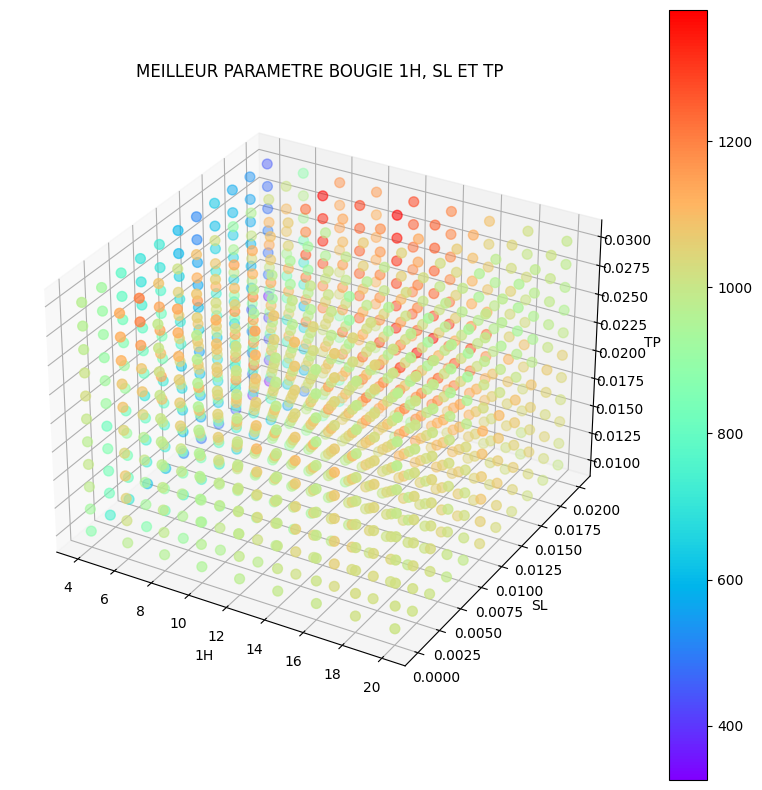

In [25]:
# print best params graph
printBestParametersValues(dfResult)

# print 3D best params graph
printBestParametersValuesGraph(dfResult)

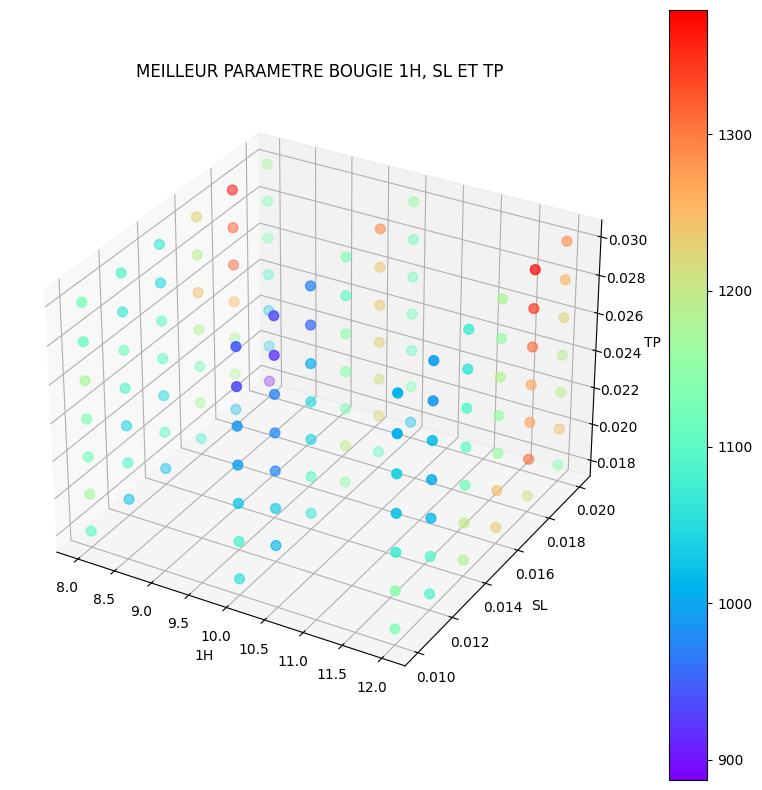

In [45]:
# zoom in
tstt = dfResult[(dfResult["SL"] >= 0.01)]
tstt = tstt[(tstt["TP"] >= 0.018)]
tstt = tstt[(tstt["1H"] >= 8)]
tstt = tstt[(tstt["1H"] <= 12)]

# print 3D best params graph
printBestParametersValuesGraph(tstt)

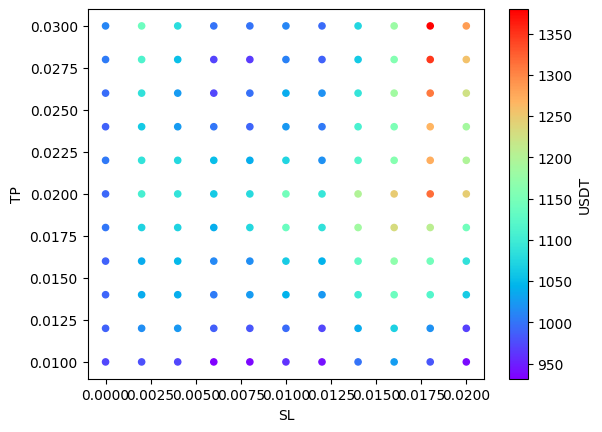

In [37]:
# création du graphique
dfPlotTpSl = dfResult[dfResult["1H"] == 12]
dfPlotTpSl.plot.scatter(x='SL', y='TP', c='USDT', colormap='rainbow')
plt.show()

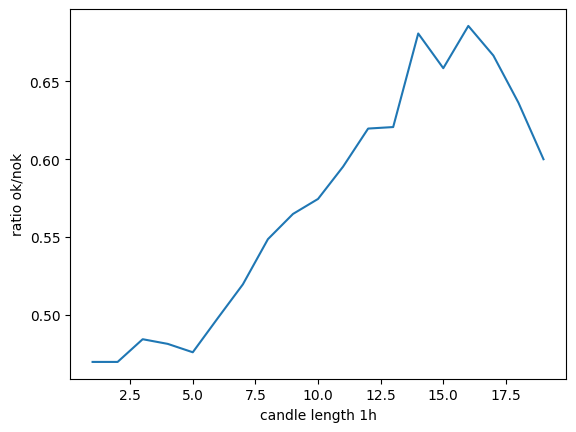

In [28]:
printBougie1hGraph(df_train, 20, 0.018, 0.02)

##### Exploration Result

In [ ]:
df_train["tune"] = 0

# Recuperere les données liés a la gestion du portefeuille apres chaque trade (df, usdt, simpleSLRatio, simpleTPRatio, simpleBougie1h, simpleBougie24h)
df_train, tabTune, mostWinInARow, mostLossInARow, maxDrawBack, maxUsdt = getWalletStats(df_train, 1000, 0.018, 0.02, 12, 8)

Most WIN in a row : 11
Most LOSS in a row : 4
Draw Back Max : 8.775372743542874%
ATH Wallet : 1407.0359137865694$


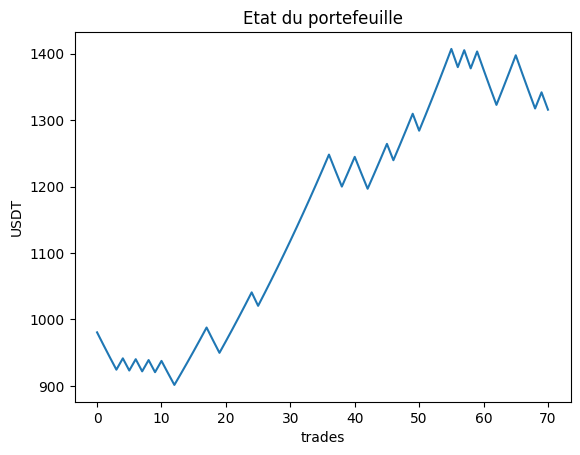

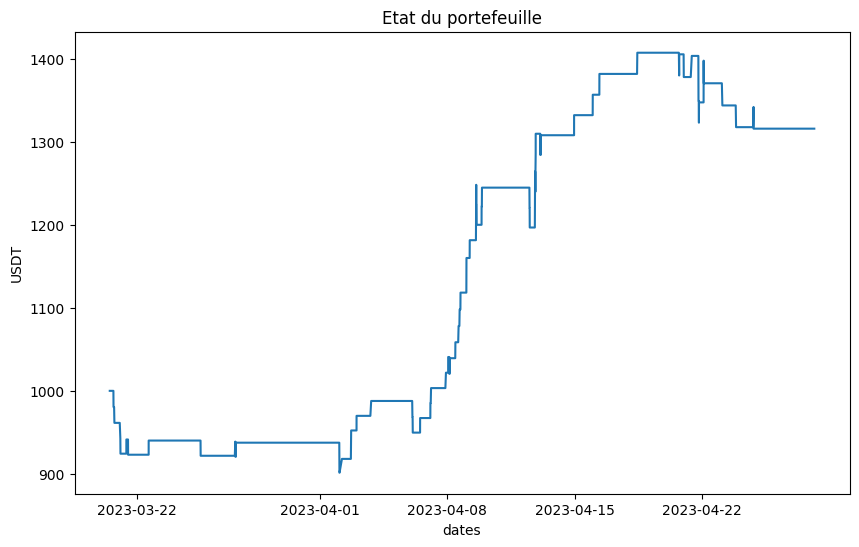

In [43]:
# Affiche les statistiques liés a la gestion du portefeuille
printWalletStats(mostWinInARow, mostLossInARow, maxDrawBack, maxUsdt)

# print 2D wallet graph / trades
printWalletGraph(tabTune)

# print 2D wallet graph / day
printTest(df_train)

##### Testing

In [ ]:
df_test["tune"] = 0

# Recuperere les données liés a la gestion du portefeuille apres chaque trade (df, usdt, simpleSLRatio, simpleTPRatio, simpleBougie1h, simpleBougie24h)
df_test, tabTune, mostWinInARow, mostLossInARow, maxDrawBack, maxUsdt = getWalletStats(df_test, 1000, 0.018, 0.02, 12, 8)

Most WIN in a row : 2
Most LOSS in a row : 5
Draw Back Max : 10.332184002373811%
ATH Wallet : 1014.3121666197494$


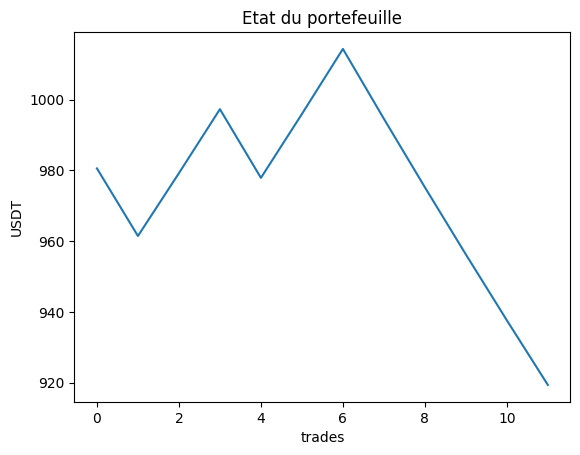

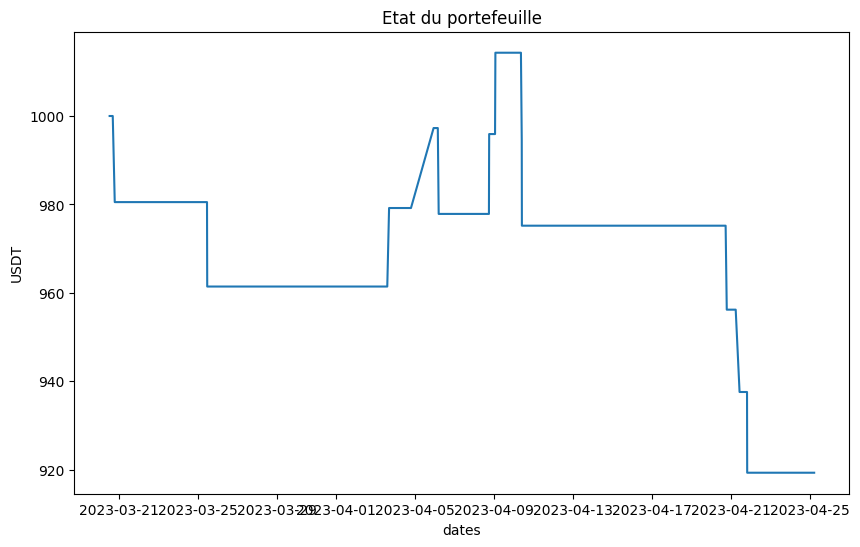

In [41]:
# Affiche les statistiques liés a la gestion du portefeuille
printWalletStats(mostWinInARow, mostLossInARow, maxDrawBack, maxUsdt)

# print 2D wallet graph / trades
printWalletGraph(tabTune)

# print 2D wallet graph / day
printTest(df_test)

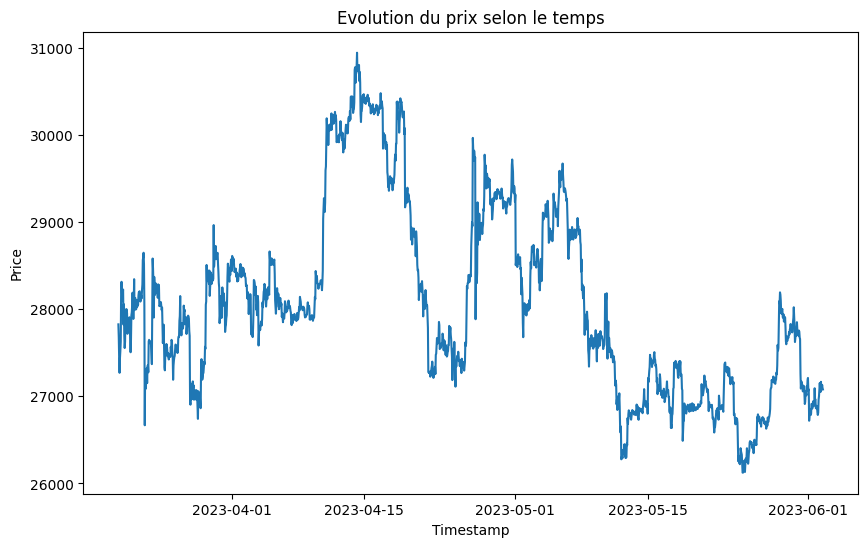

In [33]:
dfBTC = get_bitcoin_data('2023-03-20 00:00:00')

dfBTC.index = pd.to_datetime(dfBTC.index)

plot_bitcoin_data(dfBTC)